In [2]:
import numpy
import matplotlib.pyplot as plt

from objects import NormalModel, TransitionModel
from utils import rand_obs, rand_nnd, model_extract, random_nan
from dataload import weather_dataframe
from config import CSV_PATH

In [3]:
dataset = weather_dataframe(CSV_PATH)

data_array = dataset[["humidity(%)", "TEMPCORR"]].to_numpy(dtype=float)

data_array = random_nan(data_array[0:3], 3)

data_array[numpy.array([0,1,2])]

array([[82.  ,   nan],
       [  nan, 11.12],
       [  nan, 12.11]])

In [4]:
# Model's observable period
period: "int" = 75

# Model's predicted period
beyond_period: "int" = len(data_array) - period


# Dimensional parameters
n: "int" = 1
m: "int" = data_array.shape[1]

In [5]:
from components import ComponentFactory, covariate_matrix_generator
import numpy

m_1 = ComponentFactory().create_polynomial(1)

m_2 = ComponentFactory().create_harmonics(1,3)

f_1_1 = m_1.transition_matrix

f_2_1 = covariate_matrix_generator(m_2.dimension, m_1.observation_matrix)

f_1_2 = covariate_matrix_generator(m_1.dimension, m_2.observation_matrix)

f_2_2 = m_2.transition_matrix

h_1 = covariate_matrix_generator(m, m_1.observation_matrix, [0])

h_2 = covariate_matrix_generator(m, m_2.observation_matrix, [0])

f_matrix = numpy.block([[f_1_1, f_1_2],[f_2_1, f_2_2]])

h_matrix = numpy.block([[h_1, h_2]])

p: "int" = f_matrix.shape[1]


In [6]:
# Primordial model setting
n0: "NormalModel" = rand_obs((p,n))
n0.covariance = rand_nnd(p, 1)

# Evolver setting
b_e: "numpy.array" = numpy.zeros((p, n)) # p by n
a_e: "numpy.array" = f_matrix # p by p
v_e: "numpy.array" = numpy.eye(p) * 1
te = TransitionModel(b_e, a_e, v_e)

# Predictor setting
b_p: "numpy.array" = numpy.zeros((m, n)) # m by n
a_p: "numpy.array" = h_matrix # m by p
v_p: "numpy.array" = numpy.eye(m) * 50
tp = TransitionModel(b_p, a_p, v_p)

In [7]:
import funcs
import memory

prime_memory = memory.PrimeMemoryDLM(
    forward_period=period,
    beyond_period=beyond_period,
    primordial_model=n0,
    evolver=te,
    observer=tp,
    observations=data_array
)

ImportError: cannot import name 'TransitionDensity' from 'objects' (/home/seelmath/Desktop/im_dissertation/dlm_dissertation/objects.py)

In [ ]:
new_memory = funcs.forward(prime_memory=prime_memory)
new_memory = funcs.backward(prime_memory=prime_memory, memory=new_memory)
new_memory = funcs.beyond(prime_memory=prime_memory, memory=new_memory)

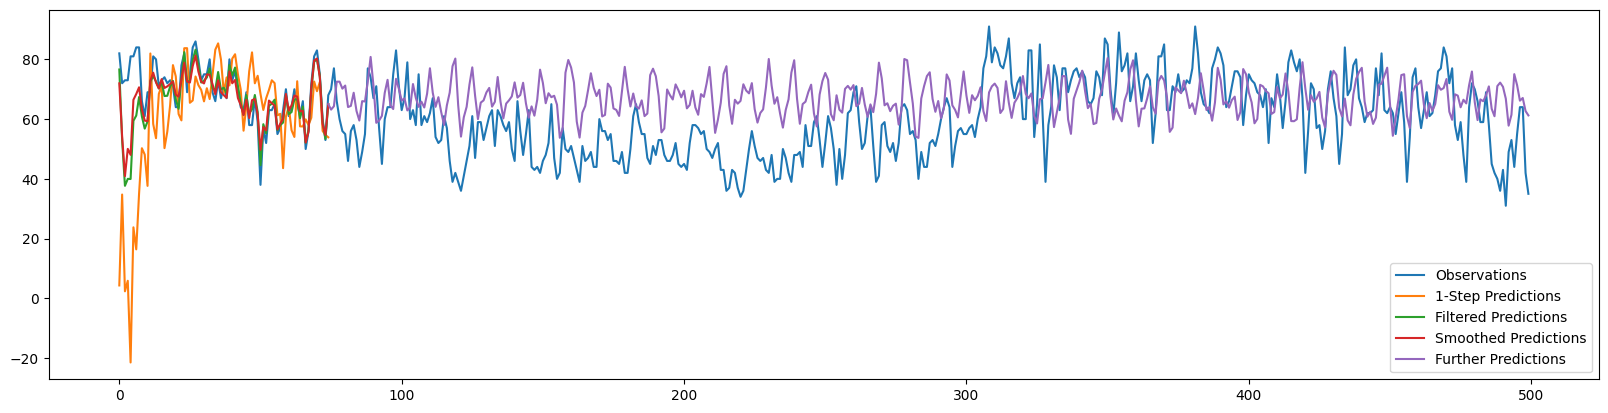

In [ ]:
index=0

fig, ax = plt.subplots()

x0_data = list(range(len(data_array)))
x1_data = list(range(period))
x2_data = list(range(period-1, period + beyond_period))

y1_data = data_array[:,index]
y2_data = list(model_extract(new_memory.evolved_spaces, index))
y3_data = list(model_extract(new_memory.filtered_spaces, index))
y4_data = list(model_extract(new_memory.smoothed_spaces, index))
y5_data = list(model_extract(new_memory.predicted_spaces, index))

ax.plot(x0_data, y1_data, label="Observations")
ax.plot(x1_data, y2_data, label="1-Step Predictions")
ax.plot(x1_data, y3_data, label="Filtered Predictions")
ax.plot(x1_data, y4_data, label="Smoothed Predictions")
ax.plot(x2_data, y5_data, label="Further Predictions")

ax.legend()
fig.set_figwidth(20)
plt.show()